In [1]:
from keras.layers import Dense,BatchNormalization,Dropout
from keras.models import Sequential,load_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers

#traditional ML methods
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#preprocessing
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# from nltk.corpus import wordnet
import re
import nltk

#others
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\57468\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\57468\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\57468\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\57468\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
#reference: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
import os
os.environ['PYTHONHASHSEED']='2233'

import random
random.seed(2233)

import numpy as np
np.random.seed(2233)

import tensorflow as tf
from tensorflow import set_random_seed
set_random_seed(2233)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
import json
from sklearn.metrics import precision_recall_fscore_support

def score(y_true,y_pred):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, pos_label=1, average="binary")
    return p,r,f

In [4]:
trainset = json.load(open('C:/Users/57468/Desktop/project-files/train.json'))
devset = json.load(open('C:/Users/57468/Desktop/project-files/dev.json'))
testset = json.load(open('C:/Users/57468/Desktop/project-files/test-unlabelled.json'))
print(len(trainset),len(devset),len(testset))

traindata = [val['text'] for val in trainset.values()]
trainlabels = [val['label'] for val in trainset.values()]

devdata = [val['text'] for val in devset.values()]
devlabels = [val['label'] for val in devset.values()]

# devlabels = json.load(open('dev-baseline-r.json'))
# devlabels = [val["label"] for val in devlabels.values()]

testdata = [val['text'] for val in testset.values()]

1168 100 1410


23 34708 3538.2731164383563


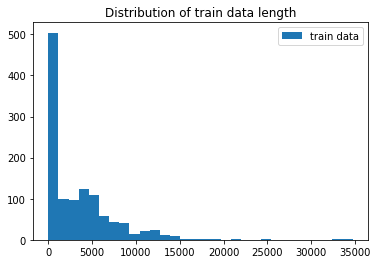

In [5]:
#show the length of traindata 
text_length = np.array([len(x) for x in traindata])
print(min(text_length),max(text_length),np.mean(text_length))

plt.hist(text_length, label='train data', bins=30)
plt.legend()
plt.title('Distribution of train data length');

5536
23 5062 1252.7817919075144


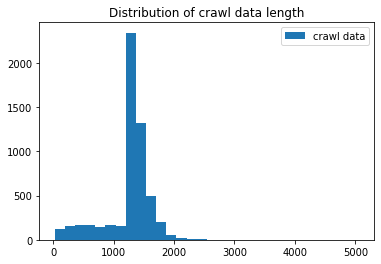

In [6]:
crawlset = json.load(open('crawldata_6M.json'))
lines = [val['text'] for val in crawlset.values()]
print(len(lines))
#show the length of crawldata 
text_length = np.array([len(x) for x in lines])
print(min(text_length),max(text_length),np.mean(text_length))

plt.hist(text_length, label='crawl data', bins=30)
plt.legend()
plt.title('Distribution of crawl data length');

In [7]:
traindata+=lines
trainlabels+=[0]*len(lines)


In [8]:
# Pre-Processing Data
stop = stopwords.words('english')
stemmer = PorterStemmer()
def clean(text):
    text = BeautifulSoup(text, "lxml").get_text() #clean HTML
    text = text.lower() #lower case
    tokens = word_tokenize(text) #tokenize
    tokens = [re.sub(r'[^a-z ]', r'', token) for token in tokens] 
#     tokens = [t for t in tokens if re.match(r'[a-z ]',t)!=None] #remove punctuations and numbers
    tokens = [token for token in tokens if token not in stop and token!='']
    tokens = [stemmer.stem(t) for t in tokens] #stemming
    text=' '.join(tokens)
    return text

clean_trainset = [clean(text) for text in traindata]
clean_devset = [clean(text) for text in devdata]
clean_testset = [clean(text) for text in testdata]

In [9]:
from collections import Counter
counts=Counter()
for sent in clean_trainset:
    for w in sent.split():
        counts[w]+=1
counts = sorted(counts.items(),key=lambda x:x[1],reverse=True)
print(len(counts))
print(counts[:10])
subset = [w for w,v in counts if v>25]
print(len(subset))

48499
[('climat', 12399), ('chang', 6551), ('year', 5414), ('said', 4605), ('would', 4383), ('one', 3909), ('new', 3863), ('govern', 3577), ('peopl', 3558), ('global', 3472)]
4353


TFIDF

In [10]:
# from sklearn.feature_extraction.text import CountVectorizer
#traditional ML methods: TFIDF + Logistic Regression\MLP\\\\
vocab_size=len(subset) #choose the top vocab_size words, ranked by tf values
tfidf = TfidfVectorizer(max_df=0.5,max_features=vocab_size) #use tfidf weights
tfidf.fit(clean_trainset)
x_train = tfidf.transform(clean_trainset)
x_dev = tfidf.transform(clean_devset)
x_test = tfidf.transform(clean_testset)
print(x_train.shape,x_test.shape)
    
ind=list(range(len(traindata)))
random.shuffle(ind)
x_train = x_train[ind]

y_train = np.array(trainlabels)[ind]

y_dev = np.array(devlabels)

(6704, 4353) (1410, 4353)


In [11]:
print(tfidf.vocabulary_)

{'flood': 1535, 'sign': 3521, 'climat': 692, 'chang': 620, 'distinguish': 1123, 'us': 4117, 'scientist': 3404, 'dr': 1163, 'roy': 3338, 'spencer': 3644, 'write': 4321, 'context': 833, 'see': 3428, 'new': 2607, 'level': 2249, 'disast': 1092, 'becom': 354, 'common': 758, 'unfold': 4087, 'certainli': 609, 'unusu': 4104, 'natur': 2577, 'weather': 4234, 'alway': 147, 'occur': 2681, 'major': 2346, 'difficult': 1075, 'compar': 765, 'throughout': 3945, 'histori': 1859, 'way': 4227, 'alter': 144, 'landscap': 2192, 'exampl': 1367, 'citi': 671, 'like': 2263, 'expand': 1385, 'year': 4332, 'soil': 3590, 'cover': 893, 'road': 3312, 'park': 2782, 'lot': 2316, 'water': 4224, 'rapidli': 3119, 'drain': 1166, 'rather': 3122, 'popul': 2933, 'ten': 3890, 'time': 3958, 'greatli': 1735, 'basic': 335, 'direct': 1084, 'un': 4067, 'intergovernment': 2052, 'panel': 2775, 'ipcc': 2075, 'releas': 3203, 'global': 1690, 'warm': 4212, 'special': 3633, 'report': 3235, 'last': 2201, 'week': 4239, 'claim': 675, 'unless'

In [12]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(x_train, y_train)


y_pred = model.predict(x_dev)

print(classification_report(devlabels,y_pred))
print(score(devlabels,y_pred))

predictions = model.predict(x_test)

print(predictions[:20])

predictions = {idx:{'label':p} for idx,p in zip(testset.keys(),predictions)}

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        else:
            return super(NpEncoder, self).default(obj)

with open('results_tfidfSVC.json', 'w') as result_file:
    result_file.write(json.dumps(predictions, cls=NpEncoder))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85        50
           1       0.95      0.70      0.80        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100

(0.9459459459459459, 0.7, 0.8045977011494254)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [13]:
lr = LogisticRegression(class_weight='balanced', solver='liblinear')
lr.fit(x_train,y_train)

print(classification_report(y_train,lr.predict(x_train)))

y_pred = lr.predict(x_dev)

print(classification_report(devlabels,y_pred))
print(score(devlabels,y_pred))

predictions = lr.predict(x_test)

predictions = {idx:{'label':p} for idx,p in zip(testset.keys(),predictions)}

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        else:
            return super(NpEncoder, self).default(obj)

with open('results_tfidflr.json', 'w') as result_file:
    result_file.write(json.dumps(predictions, cls=NpEncoder))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5536
           1       0.92      0.99      0.95      1168

    accuracy                           0.98      6704
   macro avg       0.96      0.98      0.97      6704
weighted avg       0.98      0.98      0.98      6704

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

(0.9285714285714286, 0.78, 0.8478260869565217)


In [14]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (80,))
mlp.fit(x_train,y_train)

print(classification_report(y_train,mlp.predict(x_train)))
y_pred = mlp.predict(x_dev)
print(classification_report(devlabels,y_pred))
print(score(devlabels,y_pred))

predictions = mlp.predict(x_test)
predictions = {idx:{'label':p} for idx,p in zip(testset.keys(),predictions)}

with open('results_tfidfmlp1.json', 'w') as result_file:
    result_file.write(json.dumps(predictions, cls=NpEncoder))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5536
           1       1.00      1.00      1.00      1168

    accuracy                           1.00      6704
   macro avg       1.00      1.00      1.00      6704
weighted avg       1.00      1.00      1.00      6704

              precision    recall  f1-score   support

           0       0.74      0.98      0.84        50
           1       0.97      0.66      0.79        50

    accuracy                           0.82       100
   macro avg       0.86      0.82      0.82       100
weighted avg       0.86      0.82      0.82       100

(0.9705882352941176, 0.66, 0.7857142857142857)


In [48]:
K.clear_session()

#MLP
model = Sequential()
model.add(Dense(80, input_dim=vocab_size, activation='relu')) 

model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

print(model.summary())
model.fit(x_train, y_train, validation_data=(x_dev,y_dev), epochs=5, batch_size=128)

y_pred = model.predict(x_dev) #predict on testset

y_pred = [1 if i>0.5 else 0 for i in y_pred.reshape(-1)]

print(classification_report(devlabels,y_pred))
print(score(devlabels,y_pred))

y_pred = model.predict(x_test,batch_size=128)
predictions = [1 if i>0.5 else 0 for i in y_pred.reshape(-1)]
predictions = {idx:{'label':p} for idx,p in zip(testset.keys(),predictions)}
with open('results_tfidfMLP.json', 'w') as result_file:
    result_file.write(json.dumps(predictions, cls=NpEncoder))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                348320    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 348,401
Trainable params: 348,401
Non-trainable params: 0
_________________________________________________________________
None

Train on 6704 samples, validate on 100 samples
Epoch 1/5
6704/6704 [==============================] - 1s 135us/step - loss: 0.4683 - acc: 0.8276 - val_loss: 0.7580 - val_acc: 0.5400
Epoch 2/5
6704/6704 [==============================] - 1s 111us/step - loss: 0.2103 - acc: 0.9356 - val_loss: 0.5654 - val_acc: 0.7800
Epoch 3/5
6704/6704 [==============================] - 1s 110us/step - loss: 0.1132 - acc: 0.

Error analysis

10,1.0 0.54 0.7012987012987013
20,1.0 0.62 0.7654320987654321
30,0.9393939393939394 0.62 0.7469879518072288
40,0.9393939393939394 0.62 0.7469879518072288
50,0.9696969696969697 0.64 0.7710843373493975
60,0.9393939393939394 0.62 0.7469879518072288
70,0.9411764705882353 0.64 0.7619047619047621
80,0.9393939393939394 0.62 0.7469879518072288
90,0.9411764705882353 0.64 0.7619047619047621
100,0.9411764705882353 0.64 0.7619047619047621
110,0.9411764705882353 0.64 0.7619047619047621
120,0.9696969696969697 0.64 0.7710843373493975
130,0.9411764705882353 0.64 0.7619047619047621
140,0.9696969696969697 0.64 0.7710843373493975
150,0.9411764705882353 0.64 0.7619047619047621
160,0.9696969696969697 0.64 0.7710843373493975
170,0.9411764705882353 0.64 0.7619047619047621
180,0.9696969696969697 0.64 0.7710843373493975
190,0.9411764705882353 0.64 0.7619047619047621


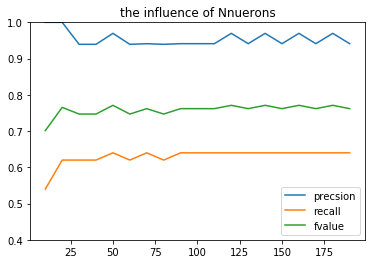

In [47]:
prfs = []
for Nnuerons in range(10,200,10):
    print(Nnuerons,end=',')
    K.clear_session()
    #MLP
    model = Sequential()
    model.add(Dense(Nnuerons, input_dim=vocab_size, activation='relu')) 
 
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

    model.fit(x_train, y_train, validation_data=(x_dev,y_dev), epochs=5, batch_size=128, verbose=False)
    y_pred = model.predict(x_dev) #predict on testset
    y_pred = [1 if i>0.5 else 0 for i in y_pred.reshape(-1)]
    
    p,r,f = score(devlabels,y_pred)
    print(p,r,f,end='\n')
    prfs.append([p,r,f])
prfs = np.array(prfs)
plt.figure()
x = range(10,200,10)
plt.plot(x,prfs[:,0],label='precision')
plt.plot(x,prfs[:,1],label='recall')
plt.plot(x,prfs[:,2],label='fvalue')
plt.legend(loc= 'lower right' )
plt.ylim([0.4,1])
plt.title('the influence of Nnuerons')
plt.show()

10,0.9705882352941176 0.66 0.7857142857142857
20,0.9696969696969697 0.64 0.7710843373493975
30,0.9705882352941176 0.66 0.7857142857142857
40,0.9705882352941176 0.66 0.7857142857142857
50,0.9705882352941176 0.66 0.7857142857142857
60,0.9705882352941176 0.66 0.7857142857142857
70,0.9705882352941176 0.66 0.7857142857142857
80,0.9705882352941176 0.66 0.7857142857142857
90,0.9696969696969697 0.64 0.7710843373493975
100,0.9705882352941176 0.66 0.7857142857142857
110,0.9705882352941176 0.66 0.7857142857142857
120,0.9705882352941176 0.66 0.7857142857142857
130,0.9705882352941176 0.66 0.7857142857142857
140,0.9705882352941176 0.66 0.7857142857142857
150,0.9705882352941176 0.66 0.7857142857142857
160,0.9705882352941176 0.66 0.7857142857142857
170,0.9705882352941176 0.66 0.7857142857142857
180,0.9705882352941176 0.66 0.7857142857142857
190,0.9705882352941176 0.66 0.7857142857142857


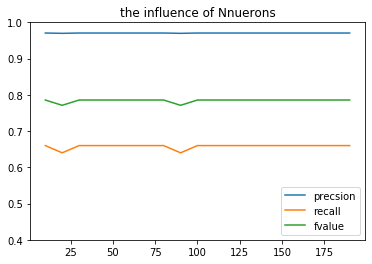

In [48]:
from sklearn.neural_network import MLPClassifier
prfs = []


for Nnuerons in range(10,200,10):
    print(Nnuerons,end=',')
    mlp = MLPClassifier(hidden_layer_sizes = (Nnuerons,))
    mlp.fit(x_train,y_train) 
    y_pred = mlp.predict(x_dev)
    p,r,f = score(devlabels,y_pred)
    print(p,r,f,end='\n')
    prfs.append([p,r,f])
prfs = np.array(prfs)
plt.figure()
x = range(10,200,10)
plt.plot(x,prfs[:,0],label='precsion')
plt.plot(x,prfs[:,1],label='recall')
plt.plot(x,prfs[:,2],label='fvalue')
plt.legend(loc= 'lower right' )
plt.ylim([0.4,1])
plt.title('the influence of Nnuerons')
plt.show()

(6704, 500) (100, 500),0.8888888888888888 0.8 0.8421052631578948
(6704, 1000) (100, 1000),0.8863636363636364 0.78 0.8297872340425532
(6704, 1500) (100, 1500),0.9069767441860465 0.78 0.8387096774193548
(6704, 2000) (100, 2000),0.9069767441860465 0.78 0.8387096774193548
(6704, 2500) (100, 2500),0.9047619047619048 0.76 0.8260869565217391
(6704, 3000) (100, 3000),0.9047619047619048 0.76 0.8260869565217391
(6704, 3500) (100, 3500),0.9069767441860465 0.78 0.8387096774193548
(6704, 4000) (100, 4000),0.9285714285714286 0.78 0.8478260869565217
(6704, 4500) (100, 4500),0.9285714285714286 0.78 0.8478260869565217
(6704, 5000) (100, 5000),0.926829268292683 0.76 0.8351648351648352
(6704, 5500) (100, 5500),0.9285714285714286 0.78 0.8478260869565217
(6704, 6000) (100, 6000),0.925 0.74 0.8222222222222222
(6704, 6500) (100, 6500),0.925 0.74 0.8222222222222222
(6704, 7000) (100, 7000),0.925 0.74 0.8222222222222222
(6704, 7500) (100, 7500),0.925 0.74 0.8222222222222222
(6704, 8000) (100, 8000),0.925 0.74 

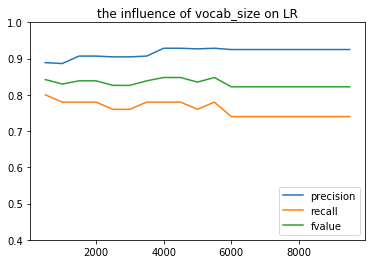

In [49]:
prfs = []
for vocab_size in range(500,10000,500):
    tfidf = TfidfVectorizer(max_df=0.5,max_features=vocab_size) #use tfidf weights
    tfidf.fit(clean_trainset)
    x_train = tfidf.transform(clean_trainset)
    x_dev = tfidf.transform(clean_devset)
    print(x_train.shape,x_dev.shape,end=',')

    ind=list(range(len(traindata)))
    random.shuffle(ind)
    x_train = x_train[ind]
    y_train = np.array(trainlabels)[ind]

    lr = LogisticRegression(C=1, solver='saga',class_weight='balanced')
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_dev)
    p,r,f = score(devlabels,y_pred)
    print(p,r,f)
    prfs.append([p,r,f])

prfs = np.array(prfs)
plt.figure()
x = range(500,10000,500)
plt.plot(x,prfs[:,0],label='precision')
plt.plot(x,prfs[:,1],label='recall')
plt.plot(x,prfs[:,2],label='fvalue')
plt.legend(loc= 'lower right' )
plt.ylim([0.4,1])
plt.title('the influence of vocab_size on LR')
plt.show()

(6704, 500) (100, 500),1.0 0.68 0.8095238095238095
(6704, 1000) (100, 1000),0.9736842105263158 0.74 0.8409090909090909
(6704, 1500) (100, 1500),1.0 0.74 0.8505747126436781
(6704, 2000) (100, 2000),1.0 0.72 0.8372093023255813
(6704, 2500) (100, 2500),1.0 0.7 0.8235294117647058
(6704, 3000) (100, 3000),0.9714285714285714 0.68 0.8
(6704, 3500) (100, 3500),0.9444444444444444 0.68 0.7906976744186047
(6704, 4000) (100, 4000),0.9444444444444444 0.68 0.7906976744186047
(6704, 4500) (100, 4500),0.9459459459459459 0.7 0.8045977011494254
(6704, 5000) (100, 5000),0.9444444444444444 0.68 0.7906976744186047
(6704, 5500) (100, 5500),0.9722222222222222 0.7 0.813953488372093
(6704, 6000) (100, 6000),0.9444444444444444 0.68 0.7906976744186047
(6704, 6500) (100, 6500),1.0 0.68 0.8095238095238095
(6704, 7000) (100, 7000),1.0 0.68 0.8095238095238095
(6704, 7500) (100, 7500),1.0 0.68 0.8095238095238095
(6704, 8000) (100, 8000),0.9714285714285714 0.68 0.8
(6704, 8500) (100, 8500),0.9714285714285714 0.68 0.8


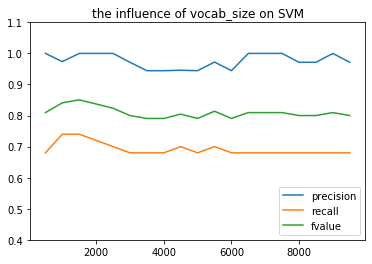

In [15]:
from sklearn.svm import LinearSVC
prfs = []
for vocab_size in range(500,10000,500):
    tfidf = TfidfVectorizer(max_df=0.5,max_features=vocab_size) #use tfidf weights
    tfidf.fit(clean_trainset)
    x_train = tfidf.transform(clean_trainset)
    x_dev = tfidf.transform(clean_devset)
    print(x_train.shape,x_dev.shape,end=',')

    ind=list(range(len(traindata)))
    random.shuffle(ind)
    x_train = x_train[ind]
    y_train = np.array(trainlabels)[ind]
    

    model = LinearSVC()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_dev)
    p,r,f = score(devlabels,y_pred)
    print(p,r,f)
    prfs.append([p,r,f])

prfs = np.array(prfs)
plt.figure()
x = range(500,10000,500)
plt.plot(x,prfs[:,0],label='precision')
plt.plot(x,prfs[:,1],label='recall')
plt.plot(x,prfs[:,2],label='fvalue')
plt.legend(loc= 'lower right' )
plt.ylim([0.4,1.1])
plt.title('the influence of vocab_size on SVM')
plt.show()

(6704, 500) (100, 500),0.9487179487179487 0.74 0.8314606741573033
(6704, 1000) (100, 1000),0.9459459459459459 0.7 0.8045977011494254
(6704, 1500) (100, 1500),0.972972972972973 0.72 0.8275862068965518
(6704, 2000) (100, 2000),0.9444444444444444 0.68 0.7906976744186047
(6704, 2500) (100, 2500),0.9705882352941176 0.66 0.7857142857142857
(6704, 3000) (100, 3000),0.9696969696969697 0.64 0.7710843373493975
(6704, 3500) (100, 3500),0.9696969696969697 0.64 0.7710843373493975
(6704, 4000) (100, 4000),0.9696969696969697 0.64 0.7710843373493975
(6704, 4500) (100, 4500),0.9705882352941176 0.66 0.7857142857142857
(6704, 5000) (100, 5000),0.9705882352941176 0.66 0.7857142857142857
(6704, 5500) (100, 5500),0.9714285714285714 0.68 0.8
(6704, 6000) (100, 6000),0.9705882352941176 0.66 0.7857142857142857
(6704, 6500) (100, 6500),0.9696969696969697 0.64 0.7710843373493975
(6704, 7000) (100, 7000),0.9696969696969697 0.64 0.7710843373493975
(6704, 7500) (100, 7500),0.9696969696969697 0.64 0.7710843373493975

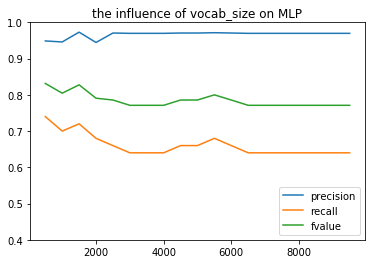

In [13]:
from sklearn.neural_network import MLPClassifier
prfs = []

for vocab_size in range(500,10000,500):
    tfidf = TfidfVectorizer(max_df=0.5,max_features=vocab_size) #use tfidf weights
    tfidf.fit(clean_trainset)
    x_train = tfidf.transform(clean_trainset)
    x_dev = tfidf.transform(clean_devset)
    print(x_train.shape,x_dev.shape,end=',')

    ind=list(range(len(traindata)))
    random.shuffle(ind)
    x_train = x_train[ind]
    y_train = np.array(trainlabels)[ind]

    mlp2 = MLPClassifier(hidden_layer_sizes= (80,))
    mlp2.fit(x_train,y_train) 
    y_pred = mlp2.predict(x_dev)
    p,r,f = score(devlabels,y_pred)
    print(p,r,f)
    prfs.append([p,r,f])

prfs = np.array(prfs)
plt.figure()
x = range(500,10000,500)
plt.plot(x,prfs[:,0],label='precision')
plt.plot(x,prfs[:,1],label='recall')
plt.plot(x,prfs[:,2],label='fvalue')
plt.legend(loc= 'lower right' )
plt.ylim([0.4,1])
plt.title('the influence of vocab_size on MLP')
plt.show()

1168
0.8043478260869565 0.74 0.7708333333333333
1752
0.8571428571428571 0.72 0.782608695652174
2336
0.8863636363636364 0.78 0.8297872340425532
2920
0.8837209302325582 0.76 0.8172043010752689
3504
0.8863636363636364 0.78 0.8297872340425532
4088
0.9069767441860465 0.78 0.8387096774193548


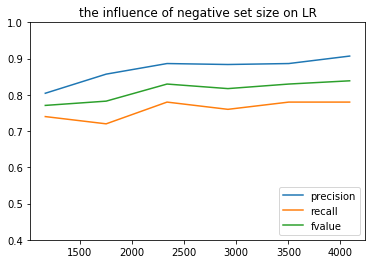

In [13]:
# error analysis
n = 1168 #positive set size
nega_samples = []
prfs = []
for i in range(2,8):
    c = int(n*i*0.5)
    nega_samples.append(c)
    print(c)
    tfidf = TfidfVectorizer(max_df=0.5,max_features=4000)
    sub_trainset = clean_trainset[:n+c] #positive set size+negative set size
    tfidf.fit(sub_trainset)
    x_train = tfidf.transform(sub_trainset)
    x_dev = tfidf.transform(clean_devset)
    
    ind=list(range(x_train.shape[0]))
    random.shuffle(ind)
    x_train = x_train[ind]
    y_train = np.array(trainlabels)[ind]
    
    lr = LogisticRegression(C=1, solver='saga',class_weight='balanced')
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_dev)
    p,r,f = score(devlabels,y_pred)
    print(p,r,f)
    prfs.append([p,r,f])

prfs = np.array(prfs)
plt.figure()
x = nega_samples
plt.plot(x,prfs[:,0],label='precision')
plt.plot(x,prfs[:,1],label='recall')
plt.plot(x,prfs[:,2],label='fvalue')
plt.legend(loc= 'lower right' )
plt.ylim([0.4,1])
plt.title('the influence of negative set size on LR')
plt.show()

1168
0.8636363636363636 0.76 0.8085106382978724
1752
0.9024390243902439 0.74 0.8131868131868132
2336
0.8974358974358975 0.7 0.7865168539325842
2920
0.918918918918919 0.68 0.7816091954022989
3504
0.918918918918919 0.68 0.7816091954022989
4088
0.9444444444444444 0.68 0.7906976744186047


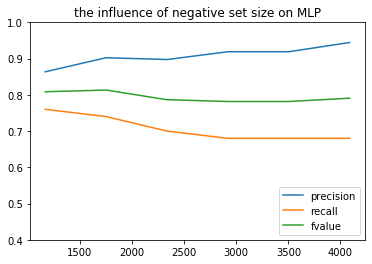

In [16]:
# error analysis
from sklearn.neural_network import MLPClassifier
n = 1168 #positive set size
nega_samples = []
prfs = []
for i in range(2,8):
    c = int(n*i*0.5)
    nega_samples.append(c)
    print(c)
    tfidf = TfidfVectorizer(max_df=0.5,max_features=4000)
    sub_trainset = clean_trainset[:n+c] #positive set size+negative set size
    tfidf.fit(sub_trainset)
    x_train = tfidf.transform(sub_trainset)
    x_dev = tfidf.transform(clean_devset)
    
    ind=list(range(x_train.shape[0]))
    random.shuffle(ind)
    x_train = x_train[ind]
    y_train = np.array(trainlabels)[ind]
    
    mlp3 = MLPClassifier(hidden_layer_sizes= (80,))
    mlp3.fit(x_train,y_train) 
    y_pred = mlp3.predict(x_dev)
    p,r,f = score(devlabels,y_pred)
    print(p,r,f)
    prfs.append([p,r,f])

prfs = np.array(prfs)
plt.figure()
x = nega_samples
plt.plot(x,prfs[:,0],label='precision')
plt.plot(x,prfs[:,1],label='recall')
plt.plot(x,prfs[:,2],label='fvalue')
plt.legend(loc= 'lower right' )
plt.ylim([0.4,1])
plt.title('the influence of negative set size on MLP')
plt.show()

1168
0.8863636363636364 0.78 0.8297872340425532
1752
0.9302325581395349 0.8 0.8602150537634408
2336
0.9047619047619048 0.76 0.8260869565217391
2920
0.9047619047619048 0.76 0.8260869565217391
3504
0.9024390243902439 0.74 0.8131868131868132
4088
0.9210526315789473 0.7 0.7954545454545453


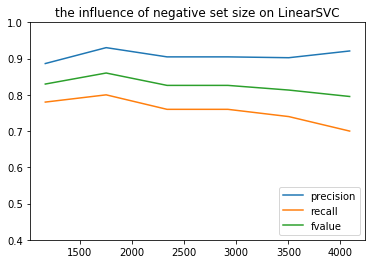

In [24]:
# error analysis
from sklearn.svm import LinearSVC
n = 1168 #positive set size
nega_samples = []
prfs = []
for i in range(2,8):
    c = int(n*i*0.5)
    nega_samples.append(c)
    print(c)
    tfidf = TfidfVectorizer(max_df=0.5,max_features=4000)
    sub_trainset = clean_trainset[:n+c] #positive set size+negative set size
    tfidf.fit(sub_trainset)
    x_train = tfidf.transform(sub_trainset)
    x_dev = tfidf.transform(clean_devset)
    
    ind=list(range(x_train.shape[0]))
    random.shuffle(ind)
    x_train = x_train[ind]
    y_train = np.array(trainlabels)[ind]
    
    model = LinearSVC()
    model.fit(x_train,y_train)
    y_pred = model.predict(x_dev)
    p,r,f = score(devlabels,y_pred)
    print(p,r,f)
    prfs.append([p,r,f])

prfs = np.array(prfs)
plt.figure()
x = nega_samples
plt.plot(x,prfs[:,0],label='precision')
plt.plot(x,prfs[:,1],label='recall')
plt.plot(x,prfs[:,2],label='fvalue')
plt.legend(loc= 'lower right' )
plt.ylim([0.4,1])
plt.title('the influence of negative set size on LinearSVC')
plt.show()